# *Goal* :
* To build a recommendation engine that automatically recommends a certain number of products to the consumers on an E-commerce website based on the past purchase behavior of the consumers

# *Data* :
* The E-Commerce data is taken from the UCI repository and can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/)

# *Solution* :
* Implemented Word2Vec model in NLP to form word embeddings for all the products
* Recommend top 'n' products for a customer based on the similarity of vectors between his purchased products and the entire products in the site

# *Code and Implementation* :
* The entire code is given in my github [repo](https://github.com/sravanroy/RecommendationSystem-Word2vec)
* The breakdown and implementation of the code is given below

### Loading the required libraries

In [4]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

### Reading the E-commerce data

In [5]:
df = pd.read_excel('Online_Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Data Preprocessing

In [6]:
# check for missing values
df.isnull().sum()

# remove missing values
df.dropna(inplace=True)

#convert stock_code to string type since it's a unique combinations of numbers and letters
df['StockCode']= df['StockCode'].astype(str)

### Train and Validation split

In [7]:
customers = df['CustomerID'].unique().tolist()

# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

### Create sequences of purchases made by the customers

In [9]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|█████████████████████████████████████████████████████████████████████████████| 3935/3935 [00:10<00:00, 374.00it/s]


In [10]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|███████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 536.36it/s]


### Build Word2Vec embeddings for products

In [49]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3649848, 3686070)

In [50]:
model.init_sims(replace=True)
print(model)


Word2Vec(vocab=3180, size=100, alpha=0.03)


### Extract the vectors for all words

In [13]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3180, 100)

### Visualize word2vec embeddings by reducing dimensions using tSNE

In [18]:
from sklearn.manifold import TSNE

In [19]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

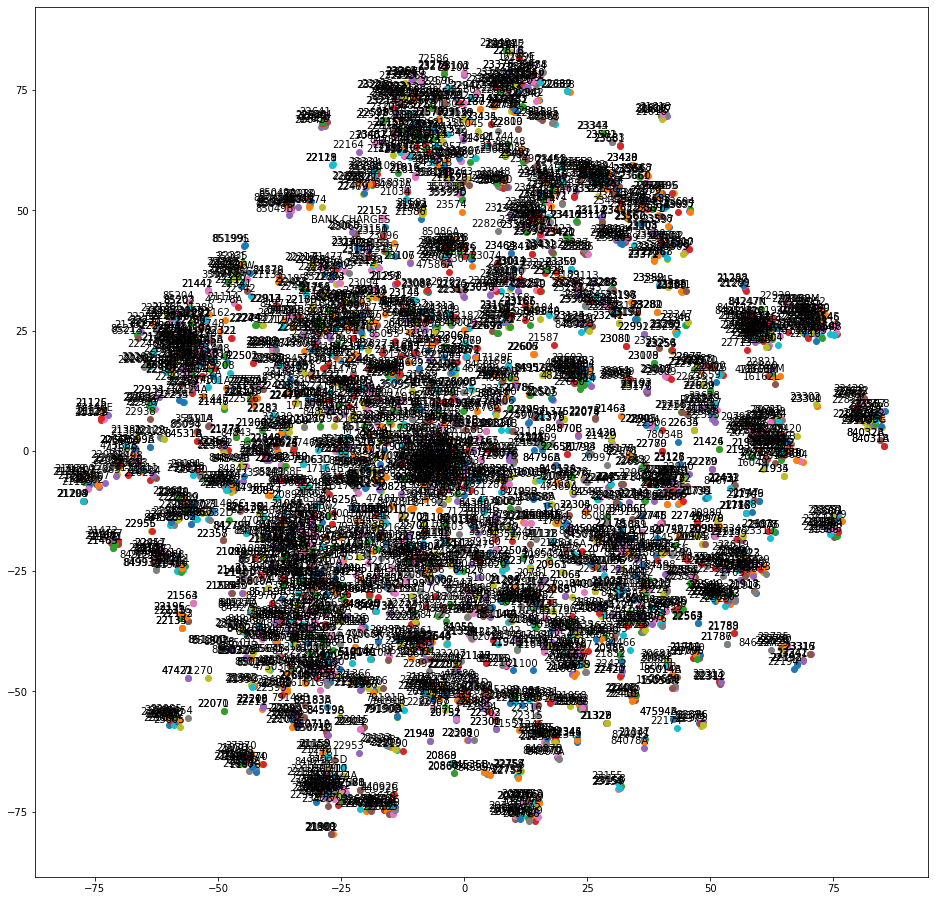

In [20]:
tsne_plot(model)

## Product Recommendations

### Creating a product ID-Description dictionary

In [38]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

### Function to return top 6 products based on a purchase

In [51]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms


### Test recommendations for a product 16218 ("CARTOON PENCIL SHARPENER")

In [54]:
similar_products(model['16218'])

[('PIECE OF CAMO STATIONERY SET', 0.7307924032211304),
 ('LETTER SHAPE PENCIL SHARPENER', 0.6984984874725342),
 ('HOUSE SHAPE PENCIL SHARPENER', 0.6939057111740112),
 ('POPART WOODEN PENCILS ASST', 0.6895440816879272),
 ('TEATIME PUSH DOWN RUBBER', 0.643091082572937),
 ('TEATIME ROUND PENCIL SHARPENER ', 0.6389858722686768)]

### Function to return the mean of vectors for recommendations based on multiple purchases

In [55]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

### Using the validation data to get recommendations based on entire purchase history of a customer

In [64]:
# pick a customer in validation data and get the mean vector of his purchases

similar_products(aggregate_vectors(purchases_val[8]))


[('SET OF 6 SPICE TINS PANTRY DESIGN', 0.678581178188324),
 ('REGENCY CAKESTAND 3 TIER', 0.6761608719825745),
 ('PARTY BUNTING', 0.6667777299880981),
 ('CREAM HANGING HEART T-LIGHT HOLDER', 0.6601625680923462),
 ('SWEETHEART 3 TIER CAKE STAND ', 0.6484372615814209),
 ('WOOD BLACK BOARD ANT WHITE FINISH', 0.6480038166046143)]

In [65]:
# recommendations based on the last 10 products purchased
similar_products(aggregate_vectors(purchases_val[8][-10:]))


[('SET OF 6 SPICE TINS PANTRY DESIGN', 0.6568060517311096),
 ('ASSORTED COLOUR BIRD ORNAMENT', 0.6506021022796631),
 ('SET OF TEA COFFEE SUGAR TINS PANTRY', 0.6362278461456299),
 ('SET OF 3 CAKE TINS PANTRY DESIGN ', 0.6203571557998657),
 ('ENAMEL MEASURING JUG CREAM', 0.6093816757202148),
 ('JAM MAKING SET PRINTED', 0.6060035228729248)]

# *End Notes*:
* As we can see, the recommendations are very close to the purchased items of a customer 
* We can tweak the code to get recommendations based on last 6 months or  1 year of purchase
* This can be applied to other domains as well other than the E-commerce 
